# Prediction of Department: Fine-Tuning a Classification Model


In [124]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, classification_report

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
from sklearn.utils import resample
from matplotlib import pyplot as plt

In [125]:
GH_USER = "luisadosch"
GH_REPO = "Final-Project-snapAddy"
BRANCH = "main"


def get_github_url(relative_path):
    return f"https://raw.githubusercontent.com/{GH_USER}/{GH_REPO}/{BRANCH}/{relative_path}"

In [126]:
jobs_annotated = pd.read_csv(get_github_url("data/processed/jobs_annotated.csv"))
df_department = pd.read_csv(get_github_url("data/raw/department-v2.csv"))

# test set from annotated CVs (ACTIVE only) -> out-of-production set
jobs_annotated_df = jobs_annotated.loc[
    jobs_annotated["status"] == "ACTIVE",
    ["position", "department"]
].copy()

jobs_annotated_df = jobs_annotated_df.rename(columns={"position": "text", "department": "label"})

# base train/test dfs (strings)
df_department = df_department[["text", "label"]].copy()
jobs_annotated_df = jobs_annotated_df[["text", "label"]].copy()

print("fine tuning data:", len(df_department), "CV labeled data:", len(jobs_annotated_df))
print("fine-tune label counts:\n", df_department["label"].value_counts())
print("out-of-production label counts:\n", jobs_annotated_df["label"].value_counts())

fine tuning data: 10145 CV labeled data: 623
fine-tune label counts:
 label
Marketing                 4295
Sales                     3328
Information Technology    1305
Business Development       620
Project Management         201
Consulting                 167
Administrative              83
Other                       42
Purchasing                  40
Customer Support            33
Human Resources             31
Name: count, dtype: int64
out-of-production label counts:
 label
Other                     344
Information Technology     62
Sales                      46
Consulting                 39
Project Management         39
Marketing                  22
Business Development       20
Human Resources            16
Purchasing                 15
Administrative             14
Customer Support            6
Name: count, dtype: int64


In [127]:
train_df_base, temp_df = train_test_split(
    df_department,
    test_size=0.30,              # 70% train, 30% temp
    stratify=df_department["label"],
    random_state=42,
)

val_df_base, df_department_test = train_test_split(
    temp_df,
    test_size=0.50,              # 15% val, 15% test
    stratify=temp_df["label"],
    random_state=42,
)

print("train:", len(train_df_base), "val:", len(val_df_base), "test:", len(df_department_test))
print("train label counts:\n", train_df_base["label"].value_counts())
print("val label counts:\n", val_df_base["label"].value_counts())
print("test label counts:\n", df_department_test["label"].value_counts())

train: 7101 val: 1522 test: 1522
train label counts:
 label
Marketing                 3006
Sales                     2330
Information Technology     913
Business Development       434
Project Management         141
Consulting                 117
Administrative              58
Other                       29
Purchasing                  28
Customer Support            23
Human Resources             22
Name: count, dtype: int64
val label counts:
 label
Marketing                 644
Sales                     499
Information Technology    196
Business Development       93
Project Management         30
Consulting                 25
Administrative             12
Other                       7
Purchasing                  6
Human Resources             5
Customer Support            5
Name: count, dtype: int64
test label counts:
 label
Marketing                 645
Sales                     499
Information Technology    196
Business Development       93
Project Management         30
Consulting      

In [128]:
def add_synthetic_department(train_df: pd.DataFrame, synthetic_csv_relpath: str) -> pd.DataFrame:
    syn = pd.read_csv(get_github_url(synthetic_csv_relpath))

    # expect columns: position, department
    syn = syn[["position", "department"]].copy()
    syn = syn.rename(columns={"position": "text", "department": "label"})
    syn = syn.dropna(subset=["text", "label"])

    out = pd.concat([train_df[["text", "label"]], syn[["text", "label"]]], ignore_index=True)
    return out


In [129]:
MODEL_CKPT = "xlm-roberta-base"
MAX_LEN = 80

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [131]:
def to_hf_dataset(df: pd.DataFrame, label_col: str = "labels") -> Dataset:
    ds = Dataset.from_pandas(df[["text", label_col]].copy(), preserve_index=False)
    ds = ds.map(tokenize, batched=True)
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", label_col])
    return ds

In [132]:
def eval_split(trainer, train_ds, val_ds, test_ds):
    train_metrics = trainer.evaluate(train_ds)
    val_metrics   = trainer.evaluate(val_ds)
    test_metrics  = trainer.evaluate(test_ds)
    print("train:", train_metrics)
    print("val:  ", val_metrics)
    print("test: ", test_metrics)
    return train_metrics, val_metrics, test_metrics

In [133]:
def loss_curves(trainer):
    logs = pd.DataFrame(trainer.state.log_history)

    train_loss = logs.dropna(subset=["loss"])[["step", "loss"]].copy()
    eval_loss  = logs.dropna(subset=["eval_loss"])[["step", "eval_loss"]].copy()

    plt.figure()
    plt.plot(train_loss["step"], train_loss["loss"])
    plt.xlabel("step")
    plt.ylabel("train loss")
    plt.title("Train loss")
    plt.show()

    plt.figure()
    plt.plot(eval_loss["step"], eval_loss["eval_loss"])
    plt.xlabel("step")
    plt.ylabel("eval loss")
    plt.title("Eval loss")
    plt.show()

    return logs

classification pipeline

In [134]:
def compute_metrics_cls(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

In [135]:
def predict_table_cls(trainer, ds, df_text_label, id2label):
    pred = trainer.predict(ds)
    probs = pred.predictions
    y_pred = np.argmax(probs, axis=-1)

    out = df_text_label.copy().reset_index(drop=True)
    out["pred_id"] = y_pred
    out["pred_label"] = [id2label[int(i)] for i in y_pred]
    out["correct"] = (out["pred_label"] == out["label"])
    return out

In [136]:
def report_cls(trainer, ds, id2label):
    pred = trainer.predict(ds)
    y_pred = np.argmax(pred.predictions, axis=-1)
    y_true = pred.label_ids
    print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))

In [137]:
def oversample_df(df, label_col="label", random_state=42):
    max_n = df[label_col].value_counts().max()
    parts = []
    for lab, g in df.groupby(label_col):
        parts.append(resample(g, replace=True, n_samples=max_n, random_state=random_state))
    return pd.concat(parts).sample(frac=1, random_state=random_state).reset_index(drop=True)


def run_classification(
    train_df,
    val_df,
    test_df,
    out_dir="dept_cls",
    do_oversample=False,
    random_state=42,
):
    # label space ONLY from train_df (no leakage)
    label_list = sorted(train_df["label"].unique())
    label2id = {l: i for i, l in enumerate(label_list)}
    id2label = {i: l for l, i in label2id.items()}

    tr = train_df.copy()
    va = val_df.copy()
    te = test_df.copy()

    tr["labels"] = tr["label"].map(label2id).astype(int)
    va["labels"] = va["label"].map(label2id)
    te["labels"] = te["label"].map(label2id)

    # oversample train only (optional)
    train_os = tr
    if do_oversample:
        train_os = oversample_df(tr, label_col="label", random_state=random_state)

    train_ds = to_hf_dataset(train_os, label_col="labels")
    val_ds = to_hf_dataset(va, label_col="labels")
    test_ds = to_hf_dataset(te, label_col="labels")

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    )

    args = TrainingArguments(
        output_dir=out_dir,
        learning_rate=1e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=10,
        weight_decay=0.05,
        warmup_ratio=0.06,
        do_eval=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        load_best_model_at_end=False,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        fp16=True,
        report_to="none",
        dataloader_num_workers=0,
        logging_strategy="steps",
        logging_steps=50,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_cls,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    trainer.train()

    eval_split(trainer, train_ds, val_ds, test_ds)
    loss_curves(trainer)

    train_pred = predict_table_cls(trainer, train_ds, train_os[["text", "label"]], id2label)
    val_pred = predict_table_cls(trainer, val_ds, va[["text", "label"]], id2label)
    test_pred = predict_table_cls(trainer, test_ds, te[["text", "label"]], id2label)

    report_cls(trainer, val_ds, id2label)

    return trainer, (train_pred, val_pred, test_pred), (label2id, id2label)


model runs

classification without synth. data

In [138]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda device count:", torch.cuda.device_count())
print("current device:", torch.cuda.current_device() if torch.cuda.is_available() else None)
print("gpu name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)

torch: 2.9.0+cu126
cuda available: True
cuda device count: 1
current device: 0
gpu name: Tesla T4


classification with synthetic data

1) Normal (no synthetic, no oversampling)

In [140]:
dept_trainer_base, (dept_train_pred, dept_val_pred, dept_test_pred), (label2id_dept, id2label_dept) = run_classification(
    train_df_base,
    val_df_base,
    df_department_test,
    out_dir="department_cls_base"
)



Map:   0%|          | 0/7101 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [ ]:
cv_dept = jobs_annotated_df[["text", "label"]].copy()
cv_dept["labels"] = cv_dept["label"].map(label2id_dept).astype(int)

cv_dept_ds = to_hf_dataset(cv_dept, label_col="labels")

cv_dept_pred = predict_table_cls(
    dept_trainer_base,
    cv_dept_ds,
    cv_dept[["text", "label"]],
    id2label_dept
)

print("CV accuracy:", cv_dept_pred["correct"].mean())
print("CV F1 macro:", f1_score(cv_dept_pred["label"], cv_dept_pred["pred_label"], average="macro"))



2) No synthetic + oversampling

In [ ]:
dept_trainer_os, (dept_train_pred, dept_val_pred, dept_test_pred), (label2id_dept, id2label_dept) = run_classification(
    train_df_base,
    val_df_base,
    df_department_test,
    out_dir="department_cls_os",
    do_oversample=True
)


In [ ]:
cv_dept_pred_os = predict_table_cls(
    dept_trainer_os,
    cv_dept_ds,
    cv_dept[["text", "label"]],
    id2label_dept
)

print("CV accuracy:", cv_dept_pred_os["correct"].mean())
print("CV F1 macro:", f1_score(cv_dept_pred_os["label"], cv_dept_pred_os["pred_label"], average="macro"))

## 3) With synthetic

In [141]:
train_df_aug = add_synthetic_department(train_df_base, "data/results/gemini_synthetic.csv")

In [142]:
# show how often the different labels occur in train_df_aug

train_df_aug["label"].value_counts()

,count
label,
Marketing,3106
Sales,2500
Information Technology,1084
Other,806
Business Development,575
Project Management,261
Consulting,244
Administrative,156
Human Resources,101


In [143]:
label2id_dept

{'Administrative': 0,
 'Business Development': 1,
 'Consulting': 2,
 'Customer Support': 3,
 'Human Resources': 4,
 'Information Technology': 5,
 'Marketing': 6,
 'Other': 7,
 'Project Management': 8,
 'Purchasing': 9,
 'Sales': 10}

In [144]:
id2label_dept

{0: 'Administrative',
 1: 'Business Development',
 2: 'Consulting',
 3: 'Customer Support',
 4: 'Human Resources',
 5: 'Information Technology',
 6: 'Marketing',
 7: 'Other',
 8: 'Project Management',
 9: 'Purchasing',
 10: 'Sales'}

Map:   0%|          | 0/8987 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3545150955.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.535000,0.206367,0.948095,0.449308
2,0.321700,0.104207,0.980289,0.772283
3,0.230400,0.077434,0.981603,0.852737
4,0.186500,0.067267,0.986859,0.926707
5,0.116200,0.069969,0.983574,0.910235
6,0.107300,0.064217,0.985545,0.928756
7,0.138000,0.063275,0.989488,0.960633
8,0.121600,0.061540,0.988830,0.934255
9,0.092100,0.065674,0.988830,0.944929


train: {'eval_loss': 0.05718054994940758, 'eval_accuracy': 0.9855346611772561, 'eval_f1_macro': 0.964477840725419, 'eval_runtime': 9.4487, 'eval_samples_per_second': 951.133, 'eval_steps_per_second': 29.739, 'epoch': 9.0}
val:   {'eval_loss': 0.06567385792732239, 'eval_accuracy': 0.9888304862023654, 'eval_f1_macro': 0.9449293658764136, 'eval_runtime': 1.6066, 'eval_samples_per_second': 947.339, 'eval_steps_per_second': 29.877, 'epoch': 9.0}
test:  {'eval_loss': 0.024626828730106354, 'eval_accuracy': 0.9934296977660972, 'eval_f1_macro': 0.944861703532089, 'eval_runtime': 1.6151, 'eval_samples_per_second': 942.377, 'eval_steps_per_second': 29.72, 'epoch': 9.0}


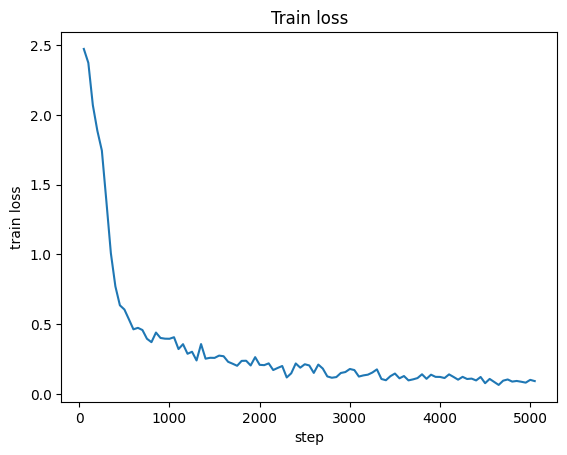

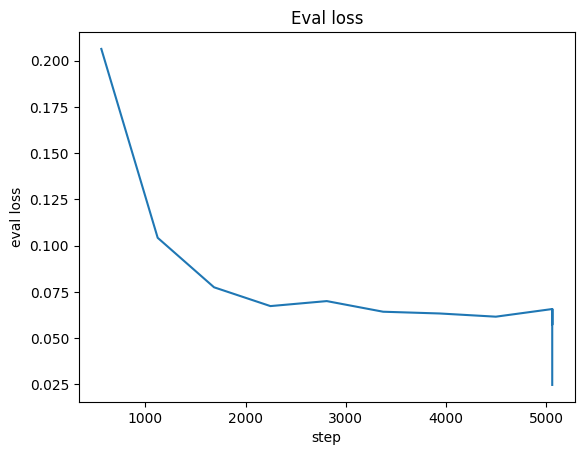

                        precision    recall  f1-score   support

        Administrative       1.00      0.83      0.91        12
  Business Development       0.98      1.00      0.99        93
            Consulting       0.86      0.96      0.91        25
      Customer Support       0.71      1.00      0.83         5
       Human Resources       1.00      1.00      1.00         5
Information Technology       0.99      0.97      0.98       196
             Marketing       1.00      1.00      1.00       644
                 Other       0.86      0.86      0.86         7
    Project Management       1.00      0.87      0.93        30
            Purchasing       1.00      1.00      1.00         6
                 Sales       0.99      1.00      0.99       499

              accuracy                           0.99      1522
             macro avg       0.94      0.95      0.94      1522
          weighted avg       0.99      0.99      0.99      1522



In [145]:
dept_trainer_aug, (dept_train_pred_aug, dept_val_pred_aug, dept_test_pred_aug), (label2id_dept, id2label_dept) = run_classification(
    train_df_aug,
    val_df_base,
    df_department_test,
    out_dir="department_cls_aug",
    do_oversample=False
)


In [148]:
cv_dept_ds = to_hf_dataset(cv_dept, label_col="labels")
dept_trainer_aug.evaluate(cv_dept_ds)

Map:   0%|          | 0/623 [00:00<?, ? examples/s]

{'eval_loss': 1.674752116203308,
 'eval_accuracy': 0.6966292134831461,
 'eval_f1_macro': 0.6481887944370125,
 'eval_runtime': 1.4311,
 'eval_samples_per_second': 435.319,
 'eval_steps_per_second': 13.975,
 'epoch': 9.0}

In [ ]:
cv_dept_pred_aug = predict_table_cls(
    dept_trainer_aug,
    cv_dept_ds,
    cv_dept[["text", "label"]],
    id2label_dept
)

print("CV accuracy:", cv_dept_pred_aug["correct"].mean())
print("CV F1 macro:", f1_score(cv_dept_pred_aug["label"], cv_dept_pred_aug["pred_label"], average="macro"))

In [ ]:
cv_dept_pred_aug